In [33]:
import tensorflow as tf

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
import librosa
import librosa.display
import librosa.feature

In [36]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
r = requests.get(url)
open(fn,'wb').write(r.content)

1418242

In [37]:
y,sr = librosa.load(fn)

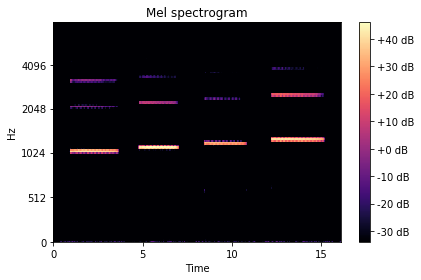

In [38]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [39]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

In [40]:
#What are the number of training and test samples?
trx,tryy = Xtr.shape
tsx,tsy = Xts.shape
ntr = trx
nts = tsx
#What is the number of features for each sample?
nfx = tryy
nfs = tsy
#How many classes (i.e. instruments) are there per class?

numClass = np.unique(ytr)

In [41]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
Xtr_mean = np.mean(Xtr, axis=0)
Xtr_std = np.std(Xtr, axis=0)
# Xtr_scale = (Xtr - Xtr_mean[None,:])/(Xtr_std[None,:]**2)
# Xts_scale = (Xts - Xtr_mean[None,:])/(Xtr_std[None,:]**2)

## may not need to square the std
Xtr_scale = (Xtr - Xtr_mean[None,:])/(Xtr_std[None,:])
Xts_scale = (Xts - Xtr_mean[None,:])/(Xtr_std[None,:])

ystd = np.std(ytr)
ymean = np.std(ytr)
#ytr = (ytr - ymean)/ystd
#yts = (yts - ymean)/ystd

In [42]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K

In [43]:
K.clear_session()

In [44]:
#nh=256 hidden units
#sigmoid activation
#select the input and output shapes correctly
#print the model summary


nh = 256
nin = Xtr_scale.shape[1]
nout = len(numClass)

model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


In [46]:
from tensorflow.keras import optimizers
# TODO
# opt = ...
# model.compile(...)

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
import tensorflow.keras.callbacks

class PeriodicPrintLoss(tensorflow.keras.callbacks.Callback):
    def __init__(self, prt_period=100):
        self.prt_period = prt_period
        
    def on_train_begin(self, logs={}):
        self.losses = []
        self.step = 0

    def on_batch_end(self, batch, logs={}):
        # Record the loss
        loss = logs.get('loss')
        self.losses.append(loss)
        
        # Print the loss periodically
        if (self.step % self.prt_period == 0):
            print('step=%6d loss=%12.4e' % (self.step, loss))
        self.step += 1
        
# Compute print period in steps 
batch_size = 100
nepoch_per_it = 2
prt_period = nepoch_per_it*int(ntr/batch_size)

# Create the callback 
loss_cb = PeriodicPrintLoss(prt_period=prt_period)

# Run the fit with the callback
hist = model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts),callbacks=[loss_cb])


Train on 66247 samples, validate on 14904 samples
Epoch 1/10
step=     0 loss=  2.4105e+00
66247/66247 [==============================] - 1s 15us/sample - loss: 0.3761 - acc: 0.9007 - val_loss: 0.1880 - val_acc: 0.9362
Epoch 2/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0925 - acc: 0.9780 - val_loss: 0.0937 - val_acc: 0.9718
Epoch 3/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0550 - acc: 0.9867 - val_loss: 0.0560 - val_acc: 0.9866
Epoch 4/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0390 - acc: 0.9902 - val_loss: 0.0457 - val_acc: 0.9886
Epoch 5/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0296 - acc: 0.9924 - val_loss: 0.0394 - val_acc: 0.9883
Epoch 6/10
66247/66247 [==============================] - 1s 14us/sample - loss: 0.0240 - acc: 0.9937 - val_loss: 0.0350 - val_acc: 0.9902
Epoch 7/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.019

Text(0, 0.5, 'accuarcy')

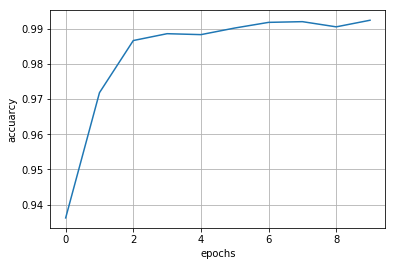

In [48]:
val_accuracy = hist.history['val_acc']
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')


Text(0, 0.5, 'semilog(loss)')

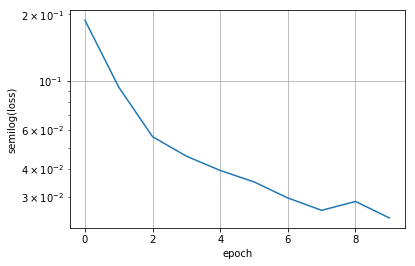

In [52]:
val_loss = hist.history['val_loss']
plt.semilogy(val_loss)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('semilog(loss)')


In [50]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
## an empty list to save val_accuracy for each lr

# TODO
# for lr in rate:
#    ...
nh = 256
nin = Xtr_scale.shape[1]
nout = len(numClass)
for lr in rates:
    K.clear_session()

    model = Sequential()
    model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(units=nout, activation='sigmoid', name='output'))
    opt = optimizers.Adam(lr=0.001)
    
    ## opt = optimizers.Adam(lr=lr)
    model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    histTemp = model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts),callbacks=[loss_cb])
    loss_hist.append(histTemp.history['val_loss'])

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
step=     0 loss=  2.4105e+00
66247/66247 [==============================] - 1s 15us/sample - loss: 0.3754 - acc: 0.9024 - val_loss: 0.1657 - val_acc: 0.9612
Epoch 2/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0945 - acc: 0.9777 - val_loss: 0.0810 - val_acc: 0.9826
Epoch 3/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0565 - acc: 0.9866 - val_loss: 0.0626 - val_acc: 0.9822
Epoch 4/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0400 - acc: 0.9902 - val_loss: 0.0510 - val_acc: 0.9855
Epoch 5/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0303 - acc: 0.9924 - val_loss: 0.0400 - val_acc: 0.9900
Epoch 6/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.0243 - acc: 0.9940 - val_loss: 0.0408 - val_acc: 0.9881
Epoch 7/10
66247/66247 [==============================] - 1s 13us/sample - loss: 0.020

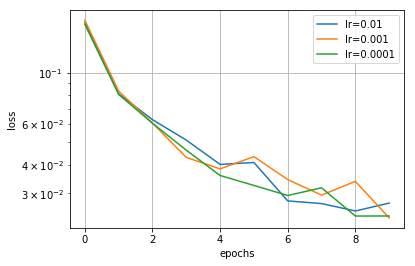

In [71]:
plt.semilogy(np.transpose(loss_hist))
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['lr=0.01', 'lr=0.001', 'lr=0.0001'])
## legend to differentiate lr